In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [2]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [3]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
datos.head()

,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,GICIS307,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
NaN,Jueves,2013-11-14,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 00:00:00
NaN,NaN,2013-11-14,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
NaN,NaN,2013-11-14,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
NaN,NaN,2013-11-14,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
NaN,NaN,2013-11-14,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00


In [4]:
datos.tail()

,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,GICIS307,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
NaN,NaN,2020-03-09,20,12140.0,6879.0,26607.0,19358.0,10983.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 19:00:00
NaN,NaN,2020-03-09,21,4313.0,31473.0,14942.0,3029.0,15129.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 20:00:00
NaN,NaN,2020-03-09,22,98.0,54796.0,33875.0,22778.0,8490.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 21:00:00
NaN,NaN,2020-03-09,23,803.0,57081.0,34073.0,36240.0,16482.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 22:00:00
NaN,NaN,2020-03-09,24,7594.0,56351.0,39697.0,45519.0,22479.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 23:00:00


In [5]:
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [6]:
n_periods = 5*24

In [7]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314','GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [8]:
columna = columns[24]
columna

'GICIS325'

In [9]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [10]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        #model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [11]:
data2 = datos[['hora',columna]]
data2[columna] = (data2[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
#data2 = data2.dropna()
data2

,hora,GICIS325
fecha_hora,,
2020-01-01 00:00:00,1,NaN
2020-01-01 01:00:00,2,NaN
2020-01-01 02:00:00,3,NaN
2020-01-01 03:00:00,4,NaN
2020-01-01 04:00:00,5,NaN
2020-01-01 05:00:00,6,NaN
2020-01-01 06:00:00,7,NaN
2020-01-01 07:00:00,8,NaN
2020-01-01 08:00:00,9,NaN


In [12]:
#Se separará por hora del día, ya que cada hora se comporta diferente.
xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]

In [13]:
#El siguiente ciclo 'for' crea un DataFrame acomodado por horas, de cada planta de generación.
for i in range(1,25):
    hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
    xhr['Hora '+str(i)] = hrs
xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Se va a trabajar con logaritmicos, porque esta transformación no afecta el vlaor, sino solo su rango.
#log = np.log(xhr+1)
log = xhr
log

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Se le cambia el index a los DataFrame creados, por las fechas que son.
xhr = xhr.set_index(pd.date_range(start=datos['fecha'][0],end=datos['fecha'][-1],freq='d'))
xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Seleccion de y_train y y_test
test = (xhr.iloc[-5:,:])   # INFO DE TEST
train = log.drop(log.index[1945:]) # QUITANDO TEST PARA TRAIN

In [17]:
train,test

(    Hora 1  Hora 2  Hora 3  Hora 4  Hora 5  Hora 6  Hora 7        Hora 8  \
 0      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 1      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 2      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 3      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 4      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 5      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 6      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 7      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 8      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 9      NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 10     NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
 11     NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   

In [18]:
fcc = []

#MODELO ARIMA
for i in range(1,25):
    y_train = train['Hora '+str(i)].dropna()

    model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
        test='adf',       # use adftest to find optimal 'd'
        max_p=4, max_q=4, # maximum p and q
        m=12,              # frequency of series
        d=None,           # let model determine 'd'
        seasonal=True,    # No Seasonality
        stepwise=True)   

    model.fit(y_train.values)
    #print(model)
    #model.plot_diagnostics(figsize=(7,5))
    #plt.show()

    # Predicción
    fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
    fcc.append(fc)

fc, model = AIC_accuracy(train,test)

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:                        SARIMAX   Log Likelihood                 462.923
Date:                Wed, 25 Mar 2020   AIC                           -921.845
Time:                        14:24:26   BIC                           -918.370
Sample:                             0   HQIC                          -920.571
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.763e-06   9.43e-14  -3.99e+07      0.000   -3.76e-06   -3.76e-06
sigma2      2.287e-11   2.97e-10      0.077      0.939    -5.6e-10    6.06e-10
===================================================================================
Ljung-Box (Q):                      900.95   Jarque-Bera (JB):                14.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.00
Prob(H) (two-sided):                  1.00   Kurtosis:                         1.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+19. Standard errors may be unstable.
"""

In [20]:
fc

[array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.7

In [21]:
fcc

[array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([19093.23313035, 26251.17997954, 24035.26056042, 27268.2451654 ,
        27408.43544031]),
 array([121011., 121011., 121011., 121011., 121011.]),
 array([126423.11206653, 121003.94328045, 135641.34076057, 131439.09486689,
        132270.44944798]),
 array([171529.94464598

In [22]:
mapes = [mape(fcc[i-1], (test['Hora '+str(i)])) for i in range(1,25)]
mapes = pd.DataFrame(mapes).dropna()
mapes[mapes == inf] = 0
mape_promedio = np.mean(mapes)

In [23]:
dias = []
for j in range(0,5):
    dias.append([([ fc[i][j] for i in range(len(fc))])][0])
pronostico = pd.DataFrame(np.concatenate(dias))
start=datos['fecha'][0]
pronostico = pronostico.set_index(pd.date_range(test.index[0],periods=len(pronostico),freq='H'))
pronostico.index = pronostico.index.map(str)

In [24]:
pronostico

,0
2020-03-05 00:00:00,-0.000004
2020-03-05 01:00:00,-0.000004
2020-03-05 02:00:00,-0.000004
2020-03-05 03:00:00,-0.000004
2020-03-05 04:00:00,-0.000004
2020-03-05 05:00:00,-0.000004
2020-03-05 06:00:00,-0.000004
2020-03-05 07:00:00,19093.233130
2020-03-05 08:00:00,121011.000000
2020-03-05 09:00:00,126423.112067


In [25]:
datos[columna][-1-19*24:]

fecha_hora
2020-02-19 23:00:00         0.0
2020-02-20 00:00:00         0.0
2020-02-20 01:00:00         0.0
2020-02-20 02:00:00         0.0
2020-02-20 03:00:00         0.0
2020-02-20 04:00:00         0.0
2020-02-20 05:00:00         0.0
2020-02-20 06:00:00         0.0
2020-02-20 07:00:00      7411.0
2020-02-20 08:00:00     62737.0
2020-02-20 09:00:00    126295.0
2020-02-20 10:00:00    178489.0
2020-02-20 11:00:00    214067.0
2020-02-20 12:00:00    237496.0
2020-02-20 13:00:00    251445.0
2020-02-20 14:00:00    233862.0
2020-02-20 15:00:00    201875.0
2020-02-20 16:00:00    143803.0
2020-02-20 17:00:00     57277.0
2020-02-20 18:00:00      9046.0
2020-02-20 19:00:00         0.0
2020-02-20 20:00:00         0.0
2020-02-20 21:00:00         0.0
2020-02-20 22:00:00         0.0
2020-02-20 23:00:00         0.0
2020-02-21 00:00:00         0.0
2020-02-21 01:00:00         0.0
2020-02-21 02:00:00         0.0
2020-02-21 03:00:00         0.0
2020-02-21 04:00:00         0.0
                         ... 

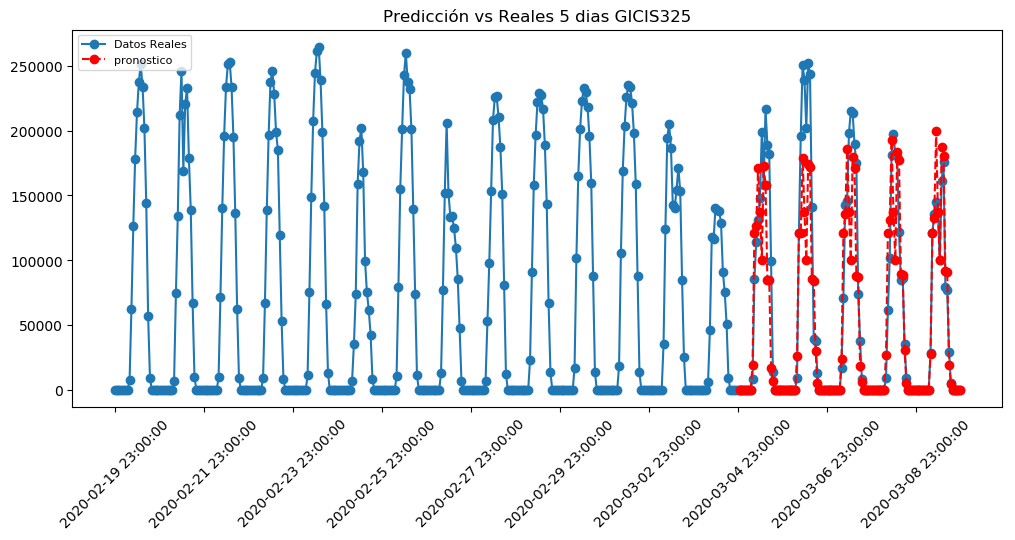

0    0.186893
dtype: float64


In [26]:
arange_dates = []
arange_no = []
arange = datos[columna][-1-19*24:].index
for i in range(0,len(arange),48):
    arange_dates.append(arange[i])
    arange_no.append(i)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(datos[columna][-1-19*24:], 'o-', label = 'Datos Reales')
plt.plot(pronostico, 'o--', label='pronostico',color ='r')
plt.title('Predicción vs Reales 5 dias '+columna)
plt.xticks(arange_no,arange_dates,rotation = 45)
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(mape_promedio)
#print(fc)
#print(model)

In [27]:
Forecasts = pd.DataFrame(fcc).dropna().T

In [28]:
Forecasts.index = test.index
Forecasts.columns = test.columns
round(Forecasts,2)

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,19093.23,121011.0,126423.11,...,157818.21,84982.37,84793.57,17042.41,6792.63,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,26251.18,121011.0,121003.94,...,171664.18,85291.98,83630.59,30086.47,5396.56,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,24035.26,121011.0,135641.34,...,171290.49,88169.38,87276.38,18205.24,5722.87,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,27268.25,121011.0,131439.09,...,177204.51,89778.24,88421.59,30751.10,5064.35,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,27408.44,121011.0,132270.45,...,180338.21,92013.79,90867.12,19358.12,4923.12,-0.0,-0.0,-0.0,-0.0,-0.0


In [29]:
test

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8047.0,85568.0,114403.0,...,216612.0,189275.0,182084.0,99357.0,13605.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9262.0,121157.0,195981.0,...,243388.0,141148.0,39031.0,37381.0,12646.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17220.0,71141.0,142718.0,...,189580.0,175035.0,74331.0,38060.0,8513.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9186.0,61458.0,101814.0,...,121717.0,84489.0,86408.0,35329.0,8908.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28284.0,121011.0,135363.0,...,176130.0,79475.0,76709.0,29432.0,5032.0,0.0,0.0,0.0,0.0,0.0


In [30]:
new_mapes = np.abs((Forecasts - test) / test)
new_mapes[new_mapes == inf] = 0

In [31]:
new_mapes

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.372714,0.414209,0.105068,...,0.271424,0.551011,0.534316,0.828473,0.500725,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.834288,0.001205,0.382573,...,0.294689,0.395727,1.142671,0.195140,0.573260,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395776,0.701002,0.049585,...,0.096474,0.496276,0.174159,0.521670,0.327749,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.968457,0.969003,0.290973,...,0.455873,0.062603,0.023303,0.129579,0.431483,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030956,0.000000,0.022846,...,0.023893,0.157770,0.184569,0.342276,0.021637,0.0,0.0,0.0,0.0,0.0


In [32]:
new_mapes[[ 'Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]

,Hora 8,Hora 9,Hora 10,Hora 11,Hora 12,Hora 13,Hora 14,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19
2020-03-05,1.372714,0.414209,0.105068,0.308480,0.076312,0.496032,0.092817,0.271424,0.551011,0.534316,0.828473,0.500725
2020-03-06,1.834288,0.001205,0.382573,0.287771,0.427037,0.503566,0.307826,0.294689,0.395727,1.142671,0.195140,0.573260
2020-03-07,0.395776,0.701002,0.049585,0.274444,0.308186,0.533985,0.158412,0.096474,0.496276,0.174159,0.521670,0.327749
2020-03-08,1.968457,0.969003,0.290973,0.062323,0.305241,0.449038,0.016122,0.455873,0.062603,0.023303,0.129579,0.431483
2020-03-09,0.030956,0.000000,0.022846,0.378452,0.000000,0.000000,0.165711,0.023893,0.157770,0.184569,0.342276,0.021637


In [33]:
np.mean(new_mapes)

Hora 1     0.000000
Hora 2     0.000000
Hora 3     0.000000
Hora 4     0.000000
Hora 5     0.000000
Hora 6     0.000000
Hora 7     0.000000
Hora 8     1.120438
Hora 9     0.417084
Hora 10    0.170209
Hora 11    0.262294
Hora 12    0.223355
Hora 13    0.396524
Hora 14    0.148178
Hora 15    0.228471
Hora 16    0.332677
Hora 17    0.411804
Hora 18    0.403428
Hora 19    0.370971
Hora 20    0.000000
Hora 21    0.000000
Hora 22    0.000000
Hora 23    0.000000
Hora 24    0.000000
dtype: float64

In [34]:
mape_final = np.mean(np.mean(new_mapes[['Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]))

In [35]:
mape_final

0.37378604053935494